# Value-based vision agent in the tetris environment using PyTorch

|        | TYPE                   | VALUES          | DESCRIPTION                                                                                                |
|--------|------------------------|-----------------|------------------------------------------------------------------------------------------------------------|
| Action Space | ndarray<br/>(1,) | {0, 1, 2, 3, 4} | Action to manipulate the current tile.<br/>0: No action<br/>1: Rotate<br/>2: Right<br/>3: Left<br/>4: Down |
| Observation Space | ndarray<br/>(210,160) | <0, 255> | The game screen. (RAM version.)                                                              |
| Reward |  | float | Reward given when a row is filled.<br/>Single: 1<br/>Double: 3<br/>Triple: 8<br/>Quadruple: 18       |
| Termination |  | boolean | The game ends when the pieces stack up to the top of the playing field.                                    |

In [1]:
import copy
import time
import torch
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt

from agents.value_vision import VisionDeepQ

In [2]:
environment = gym.make('ALE/Tetris-v5', render_mode="rgb_array", obs_type="grayscale")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


### Training

#### Parameters

In [3]:
GAMES = 30
# FRAME_SKIP = 4

GAMMA = 0.99

EXPLORATION_RATE = 1.0
EXPLORATION_DECAY = 0.995
EXPLORATION_MIN = 0.01

MINIBATCH = 64
TRAIN_EVERY = 1

MEMORY = 1500
RESET_Q_EVERY = 5

NETWORK = {"input_channels": 1, "outputs": 5, 
           "channels": [32, 64, 64],
           "kernels": [8, 4, 3],
           "strides": [4, 2, 1],
           "nodes": [64]
           }
OPTIMIZER = {"optim": torch.optim.RMSprop, "lr": 0.0001}

#### Initialisation

In [4]:
value_agent = VisionDeepQ(
    network=NETWORK, optimizer=OPTIMIZER,
    gamma=GAMMA, batch_size=MINIBATCH, memory=MEMORY,
    exploration_rate=EXPLORATION_RATE, exploration_decay=EXPLORATION_DECAY, exploration_min=EXPLORATION_MIN
)

_value_agent = copy.deepcopy(value_agent)

In [5]:
checkpoint = GAMES // 10
metrics = {
    "steps": torch.zeros(GAMES),
    "losses": torch.zeros(GAMES // TRAIN_EVERY),
    "exploration": torch.zeros(GAMES),
    "rewards": torch.zeros(GAMES)
}

#### Training

In [6]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = torch.tensor(environment.reset()[0], dtype=torch.float32).view((1, 1, 210, 160))  # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    rewards = 0
    while not (terminated or truncated):
        # if not steps % FRAME_SKIP == 0 or steps == 0:
        action = value_agent.action(state)
            
        new_state, reward, terminated, truncated, _ = environment.step(action.item())         # noqa
        new_state = torch.tensor(new_state, dtype=torch.float32).view((1, 1, 210, 160))
        
        value_agent.remember(state, action, new_state, torch.tensor([reward]))
        state = new_state
        
        steps += 1
        rewards += reward
    value_agent.memorize(steps)

    if game % TRAIN_EVERY == 0:
        loss = value_agent.learn(network=_value_agent)
        metrics["losses"][game // TRAIN_EVERY - 1] = loss
    
    if game % RESET_Q_EVERY == 0:
        _value_agent.load_state_dict(value_agent.state_dict())

    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["exploration"][game-1] = value_agent.explore["rate"]
    metrics["rewards"][game-1] = rewards
    
    if game % checkpoint == 0 or game == GAMES:
        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_loss = metrics["losses"][max(0, (game-checkpoint-1) 
                                           // TRAIN_EVERY):game // TRAIN_EVERY].mean()
        _total_rewards = metrics["rewards"][max(0, game-checkpoint-1):game-1].sum()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average loss: {_mean_loss:>13.4f} \n"
              f" > Total rewards: {int(_total_rewards):>12} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game      3               10 % 
------------------------------ 
 > Average steps:          463 
 > Average loss:        0.0676 
 > Total rewards:            0 
 
Game      6               20 % 
------------------------------ 
 > Average steps:          638 
 > Average loss:        0.0120 
 > Total rewards:            0 
 
Game      9               30 % 
------------------------------ 
 > Average steps:          592 
 > Average loss:        0.0023 
 > Total rewards:            0 
 
Game     12               40 % 
------------------------------ 
 > Average steps:          529 
 > Average loss:        0.0003 
 > Total rewards:            0 
 
Game     15               50 % 
------------------------------ 
 > Average steps:          465 
 > Average loss:        0.0001 
 > Total rewards:            0 
 
Game     18               60 % 
------------------------------ 
 > Average steps:          496 
 > Average loss:        0.0001 
 > Total rewards:            0 
 
Game     21               70

KeyboardInterrupt: 

#### Visualisation

##### Metrics

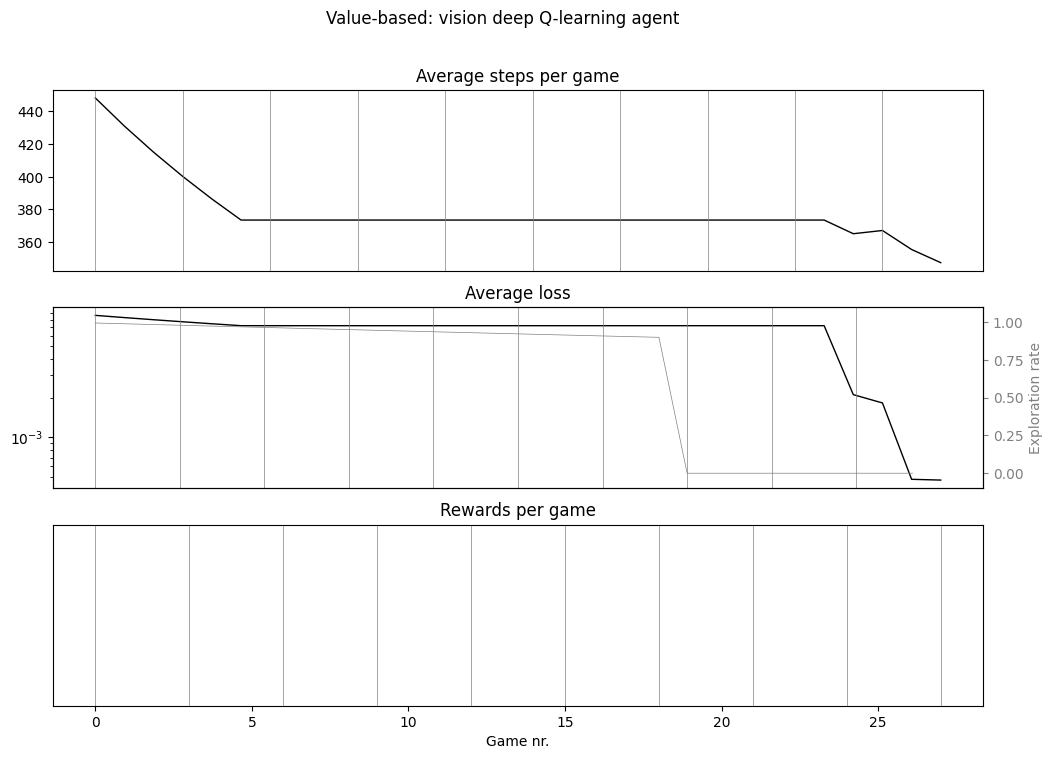

In [7]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(len(data), i+half_window)]).mean() 
            for i in range(len(data))]

steps = moving_average(metrics["steps"])
losses = moving_average(metrics["losses"])
rewards = [val.item() if val > 0 else torch.nan for val in metrics["rewards"]]

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle("Value-based: vision deep Q-learning agent")

ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].plot(torch.linspace(0, GAMES, len(losses)), losses, color="black", linewidth=1)
ax[1].set_yscale("log")
ax[1].set_xticks([])
ax[1].set_title("Average loss")

ax_2 = ax[1].twinx()
ax_2.plot(metrics["exploration"], color="gray", linewidth=0.5)
ax_2.set_ylabel("Exploration rate")
ax_2.yaxis.label.set_color('gray')
ax_2.set_ylim(-0.1, 1.1)
ax_2.tick_params(axis='y', colors='gray')

ax[2].scatter(range(len(rewards)), rewards, color="black", s=15, marker="*")
ticks = [reward for reward in rewards if not torch.isnan(torch.tensor(reward))] 
ax[2].set_yticks(torch.unique(torch.tensor(ticks)).tolist())
ax[2].set_xlabel("Game nr.")
ax[2].set_title("Rewards per game")

for i in range(0, GAMES, GAMES // 10):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)
    ax[2].axvline(x=i, color='gray', linewidth=0.5)

plt.savefig("./output/value-vision-tetris.png")
plt.show()

##### In action

In [9]:
state = torch.tensor(environment.reset()[0], dtype=torch.float32).view((1, 1, 210, 160))

images = []
terminated = truncated = False
while not (terminated or truncated):
    action = torch.argmax(value_agent(state)).item()
    
    state, reward, terminated, truncated, _ = environment.step(action)
    state = torch.tensor(state, dtype=torch.float32).view((1, 1, 210, 160))

    images.append(environment.render())
_ = imageio.mimsave('./output/value-vision-tetris.gif', images, duration=25)

/Users/Mac/anaconda3/envs/spesialpensum/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


<img src="./output/value-vision-tetris.gif" width="1000" height="1000" />

In [ ]:
environment.close()